# Experiments with Memory Access and Matrices

In many problems, especially problems accessing lots of data and doing relatively simple computations on each datum, the performance bottleneck is memory rather than computational speed.  Because memory is arranged into a **memory hierarchy** of larger/slower and smaller/faster memories, it turns out that *changing the order* of memory access can have a huge impact on performance.

In this notebook, we'll explore these performance issues with a few typical matrix algorithms, implemented in Julia.

In [1]:
using BenchmarkTools # a useful package of benchmarking utilities
versioninfo() # a useful function to print out information about the machine

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = code
  JULIA_CXX_RTTI = 1


## Benchmarking Matrix Multiplication

One of the most basic building blocks of numerical linear algebra is the computation of matrix multiplication: given an $m \times n$ matrix $A$ and an $n \times p$ matrix $B$, compute the $m \times p$ matrix $C = AB$.   The entries of $C$ are given by the exact formula:
$$
C_{ik} = \sum_{j=1}^n A_{ij} B_{jk}
$$
but there are many ways to implement this computation.   $\approx 2mnp$ flops (floating-point additions and multiplications) are required, but they can re-ordered arbitrarily, leading to $\sim (mnp)!$ possible orderings.

It turns out that the ordering of the operations in the matrix multiplication has a *huge* impact on performance, along with low-level details of the inner loops.  Basically, three factors make the implementation of efficient matrix multiplication highly nontrivial:

* [Caches](https://en.wikipedia.org/wiki/CPU_cache): the matrix accesses must be reordered to obtain [temporal locality](https://en.wikipedia.org/wiki/Locality_of_reference) and hence efficient memory (cache) usage.
* [Registers](https://en.wikipedia.org/wiki/Processor_register): at the lowest level, the CPU registers form a kind of ideal cache.  The innermost loops of the matrix multiplication need to be unrolled in order to load many values into registers and perform as much work with them as possible (essentially a small submatrix multiplication).  It turns out that a [lot of tricks](http://cscads.rice.edu/workshops/july2007/autotune-slides-07/Frigo.pdf) are required to do this well.
* [SIMD instructions](https://en.wikipedia.org/wiki/SIMD): modern CPUs include special instructions that can perform several arithmetic operations at once (e.g. 2, 4, or even 8 `Float64` operations), and to get the full benefit of these operations typically requires hand coding. 

As a consequence, there is a huge performance gap between the most obvious three-loop matrix-multiplication code and highly optimized code.  This gap has become the central factor in the design of dense linear-algebra libraries for several decades, especially the industry-standard free/open-source the [LAPACK](https://en.wikipedia.org/wiki/LAPACK) library: nearly all dense linear algebra is now organized around highly optimized [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) libraries.

Because Julia benefits from fast compilers, we can illustrate this performance gap fairly with simple Julia code.  (In contrast, similar implementation in Matlab or Python would be orders of magnitude slower, and would demonstrate mostly language rather than the algorithmic effects.)

### Naive algorithm

The following is the simplest, most obvious, matrix-multiplication algorithm: just three nested loops, implementing a dot product for each output $C_{ik}$.

The only concessions we have made to performance concerns here are (1) we implement an in-place `matmul!` variant that operates on a pre-existing `C` array, to avoid benchmarking the memory allocation/deallocation and (2) we use the `@inbounds` macro to turn off array bounds-checking in Julia for the inner loop.   Together, these make less than a factor of two difference in speed.

In [2]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.  ("!" is a Julia convention
# for functions that modify their arguments.)
function matmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    for i = 1:m, k = 1:p
        c = zero(eltype(C))
        for j = 1:n
            @inbounds c += A[i,j] * B[j,k]
        end
        @inbounds C[i,k] = c
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul(A, B) = matmul!(Array{promote_type(eltype(A), eltype(B))}(undef,
                             size(A,1), size(B,2)),
                       A, B)

matmul (generic function with 1 method)

In [3]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
using LinearAlgebra
norm(matmul(A,B) - A * B)

8.599750569898517e-16

### Naive algorithm + SIMD

All modern CPUs have special [SIMD instrucions](https://en.wikipedia.org/wiki/SIMD) that perform multiple floating-point operations simultaneously.   This gives almost a factor of 8 speedup to matrix multiplication on typical modern Intel processors thanks to hand-coded support for [AVX-512](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) SIMD instructions.

Not only that, but there are also "[fused-multiply add](https://en.wikipedia.org/wiki/FMA_instruction_set)" that perform `x + αy` in a single instruction, which can give another factor of 2 in computing dot products and matrix multiplications.

If we don't use these instructions, we lose up to a factor of 16 right off the bat, and it will be hard to compare to optimized BLAS libraries.   Fortunately, for a problem as simple as matrix multiplication, the use of SIMD can be **automated**.   You typically have to tell the compiler to do this explicitly, however, because changing the code to use SIMD **changes the floating-point result** because it requires doing operations in a different order.  (Compilers don't like to change your answers unless you give them permission!)

In particular, there is a nice Julia package called [LoopVectorization.jl](https://github.com/chriselrod/LoopVectorization.jl) that provides an `@avx` macro to rewrite simple loops to use AVX and FMA instructions.   We'll use this in a `matmul2` variant of the code above:

In [4]:
using LoopVectorization

In [5]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.  ("!" is a Julia convention
# for functions that modify their arguments.)
function matmul2!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    @avx for i = 1:m, k = 1:p
        c = zero(eltype(C))
        for j = 1:n
            @inbounds c += A[i,j] * B[j,k]
        end
        @inbounds C[i,k] = c
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul2(A, B) = matmul2!(Array{promote_type(eltype(A), eltype(B))}(undef,
                             size(A,1), size(B,2)),
                         A, B)

matmul2 (generic function with 1 method)

In [6]:
A = rand(50,60); B = rand(60,70); C = zeros(50,70);
@btime matmul!($C, $A, $B);
@btime matmul2!($C, $A, $B);

  183.287 μs (0 allocations: 0 bytes)
  10.739 μs (0 allocations: 0 bytes)


#### Benchmarking naive `matmul`

Here, we will benchmark our two naive `matmul` implementations against the highly optimized [OpenBLAS library](http://www.openblas.net/) that Julia uses for its built-in matrix multiplication.   Like `matmul!`, we will call OpenBLAS with pre-allocated output via `mul!(C, A, B)` instead of the simpler `A * B`.  By default, OpenBLAS uses multiple CPU cores, which gives it an "unfair" parallel speedup, but we can disable this for benchmarking purposes:

In [7]:
# for benchmarking, use only single-threaded BLAS:
BLAS.set_num_threads(1)

We will benchmark $n \times n$ matrix multiplications for various $n$ from 10 to 1000.  Julia's `@elapsed ...code...` macro is useful for benchmarking: it times the code and returns the time in seconds.   As we go, we will print the ratio of the naive time to the optimized time, to see the slowdown of our naive code.

In [8]:
N = round.(Int, 10 .^ range(1, log10(3000), length=60))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t = Float64[]
tv = Float64[]
t0 = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(t, @belapsed matmul!($C,$A,$B))
    push!(tv, @belapsed matmul2!($C,$A,$B))
    push!(t0, @belapsed mul!($C,$A,$B))
    println("finished n = $n: slowdown of ", t[end]/t0[end])
end

finished n = 10: slowdown of 2.2571504835754426
finished n = 11: slowdown of 2.4950691233198357
finished n = 12: slowdown of 3.5707673377490377
finished n = 13: slowdown of 3.4865546942291124
finished n = 15: slowdown of 3.599620732978466
finished n = 16: slowdown of 5.630373700477662
finished n = 18: slowdown of 5.243865125760819
finished n = 20: slowdown of 6.874664698176374
finished n = 22: slowdown of 6.387227592987055
finished n = 24: slowdown of 7.530390738060781
finished n = 26: slowdown of 7.139406668416908
finished n = 29: slowdown of 8.86996197718631
finished n = 32: slowdown of 8.063699530516432
finished n = 35: slowdown of 8.306155473952822
finished n = 39: slowdown of 7.8994731502994195
finished n = 43: slowdown of 8.78684030157642
finished n = 47: slowdown of 8.872432655588812
finished n = 52: slowdown of 11.35894960417069
finished n = 57: slowdown of 11.229594409624667
finished n = 63: slowdown of 10.679177119919718
finished n = 69: slowdown of 12.7211454513707
finished 

In [9]:
using PyPlot # a plotting library based on Python's Matplotlib

Now, we will plot the results.  Since the number of flops is $2n^3$, we will plot $2n^3 / t$ for time $t$ in microseconds in order to plot the **gigaflops rate** (billions of flops per second).  If you naively think of a CPU as a box that performs floating-point instructions at a fixed rate, with all other instructions being negligible (a picture that *may* have been true circa 1985), this would be a flat horizontal line independent of $n$, but we will see that reality is quite different.

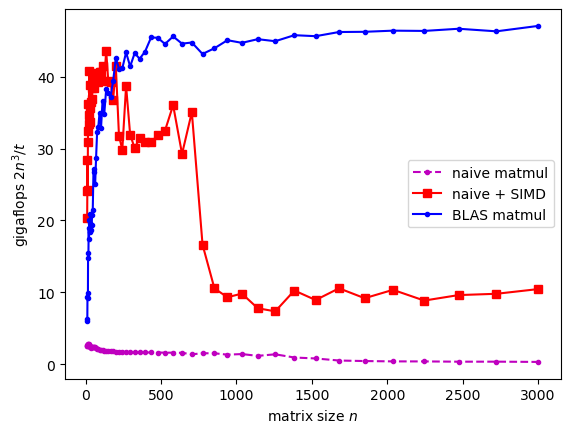

PyObject <matplotlib.legend.Legend object at 0x7f8d184ff510>

In [10]:
plot(N, 2N.^3 ./ t * 1e-9, "m.--")
plot(N, 2N.^3 ./ tv * 1e-9, "rs-")
plot(N, 2N.^3 ./ t0 * 1e-9, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "naive + SIMD", "BLAS matmul"], loc="center right")

#### Naive matmul in C

You may be suspicious that the problem is simply that Julia is slow.   We can check this hypothesis by implementing the same algorithm in C, compiling it, and then calling it by Julia's built-in `ccall` instruction that makes it [easy to call C from Julia](http://docs.julialang.org/en/latest/manual/calling-c-and-fortran-code/).

In [11]:
# C implementation:
Cmatmul = """
void Cmatmul(int m, int n, int p, double *C, double *A, double *B)
{
    int i, j, k;
    for (i = 0; i < m; ++i)
        for (j = 0; j < p; ++j) {
            double c = 0.0;
            for (k = 0; k < n; ++k)
                c += A[i + m*k] * B[k + n*j];
            C[i + m*j] = c;
    }
}
"""
# compile to a shared library by piping Cmatmul to gcc:
# (only works if you have gcc installed)
const Clib = tempname()
import Libdl
open(`gcc -fPIC -O3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, Cmatmul)
end

# define a Julia cmatmul! function that simply calls the C code in the shared library we compiled
function cmatmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    ccall(("Cmatmul", Clib), Cvoid, (Cint, Cint, Cint, Ptr{Float64}, Ptr{Float64}, Ptr{Float64}),
          m, n, p, C, A, B)
    return C
end
cmatmul(A, B) = cmatmul!(Array{promote_type(eltype(A), eltype(B))}(undef,
                               size(A,1), size(B,2)),
                         A, B)

cmatmul (generic function with 1 method)

In [12]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
norm(cmatmul(A,B) - A * B)

1.0175362097255202e-15

Now, let's benchmark it and print out the "speedup" compared to pure Julia.  We see that it is **about the same speed**.  Julia's main claim to fame is that it is a dynamic language (like Python or Matlab) that stays within a factor of 2 (usually better) of C.

finished n = 10: speedup of 0.8096392132348016
finished n = 11: speedup of 0.787933800068331
finished n = 12: speedup of 0.8429995468962392
finished n = 13: speedup of 0.8449945527175886
finished n = 15: speedup of 0.9459532739843644
finished n = 16: speedup of 0.9247698181001573
finished n = 18: speedup of 0.9302127439843024
finished n = 20: speedup of 0.8912962271199104
finished n = 22: speedup of 0.8948917748917748
finished n = 24: speedup of 0.8670125876813682
finished n = 26: speedup of 1.005001103184526
finished n = 29: speedup of 0.8989197530864198
finished n = 32: speedup of 0.9371017624920818
finished n = 35: speedup of 0.8755310778914239
finished n = 39: speedup of 0.9625932062966033
finished n = 43: speedup of 0.9251170046801873
finished n = 47: speedup of 0.9471063805036934
finished n = 52: speedup of 0.9394676004623648
finished n = 57: speedup of 0.9359114179037452
finished n = 63: speedup of 0.9298708865041629
finished n = 69: speedup of 0.9078362203859774
finished n = 76

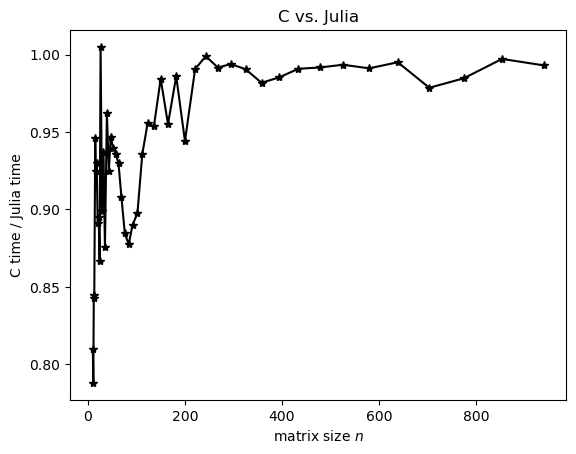

0.9930787512487544


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8d18834210>

In [13]:
tc = Float64[]
for n in N[N .<= 1000]
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tc, @belapsed cmatmul!($C,$A,$B))
    println("finished n = $n: speedup of ", tc[end]/t[length(tc)])
end

title("C vs. Julia")
xlabel(L"matrix size $n$")
ylabel("C time / Julia time")
plot(N[N .<= 1000], tc ./ t[N .<= 1000], "k*-")

### Cache-oblivious matrix-multiplication

As a first step in the right direction, we'll implement a [cache-oblivious algorithm](https://en.wikipedia.org/wiki/Cache-oblivious_algorithm) for matrix multiplication: divide the matrices into four submatrices which are multiplied *recursively* until a sufficiently large base case is reached (large enough to amortize the recursion overhead).   This strategy erases the steep performance drop-off that occurs for large $n$ where the matrix goes out-of-cache, at the cost of ~25 lines of code rather than ~10 for the naive loops.

(The "last factor of 2" in performance takes a lot more effort.  Our code still doesn't match the OpenBLAS performance because the cache-oblivious algorithm is only optimal up to constant factors, and moreover one really needs to unroll and optimize the base cases to optimize register utilization.  And then there is the effort required to parallelize the whole thing, which is not considered here.)

In contrast, OpenBLAS requires ≈1000× as much code (≈30000 lines for matrix multiplications).  A recent pure-Julia library called [Octavian.jl](https://github.com/JuliaLinearAlgebra/Octavian.jl) can match and even sometimes exceed the multi-threaded OpenBLAS performance, with "only" 100× as much code (a few thousand lines).  High-level languages + fast compilation is a convenient combination for writing high-performance code!

In [14]:
function add_matmul_rec!(m,n,p, i0,j0,k0, C,A,B)
    if m+n+p <= 256   # base case: naive matmult for sufficiently large matrices
        @avx for i = 1:m, k = 1:p
            c = zero(eltype(C))
            for j = 1:n
                @inbounds c += A[i0+i,j0+j] * B[j0+j,k0+k]
            end
            @inbounds C[i0+i,k0+k] += c
        end
    else
        m2 = m ÷ 2; n2 = n ÷ 2; p2 = p ÷ 2
        add_matmul_rec!(m2, n2, p2, i0, j0, k0, C, A, B)
        
        add_matmul_rec!(m-m2, n2, p2, i0+m2, j0, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p2, i0, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n2, p-p2, i0, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p2, i0+m2, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p-p2, i0, j0+n2, k0+p2, C, A, B)
        add_matmul_rec!(m-m2, n2, p-p2, i0+m2, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p-p2, i0+m2, j0+n2, k0+p2, C, A, B)
    end
    return C
end

function matmul_rec!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    fill!(C, 0)
    return add_matmul_rec!(m,n,p, 0,0,0, C,A,B)
end


matmul_rec(A, B) = matmul_rec!(Array{promote_type(eltype(A), eltype(B))}(undef,
                                     size(A,1), size(B,2)),
                               A, B)

matmul_rec (generic function with 1 method)

In [15]:
# correctness check:
A = rand(50,60)
B = rand(60,70)
norm(matmul_rec(A,B) - A * B)

0.0

In [16]:
tco = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tco, @belapsed matmul_rec!($C,$A,$B))
    println("finished n = $n: slowdown of ", tco[end]/t0[length(tco)])
end

finished n = 10: slowdown of 0.42001787059144474
finished n = 11: slowdown of 0.3744457778506396
finished n = 12: slowdown of 0.5041604323980581
finished n = 13: slowdown of 0.5199141574397629
finished n = 15: slowdown of 0.4199135366588606
finished n = 16: slowdown of 0.5527778677231711
finished n = 18: slowdown of 0.5997538447503661
finished n = 20: slowdown of 0.6598303216818115
finished n = 22: slowdown of 0.6105471661213682
finished n = 24: slowdown of 0.6054457506492477
finished n = 26: slowdown of 0.6547650301916514
finished n = 29: slowdown of 0.667514258555133
finished n = 32: slowdown of 0.5813784037558685
finished n = 35: slowdown of 0.587218107508143
finished n = 39: slowdown of 0.5800459766353611
finished n = 43: slowdown of 0.6574409521633646
finished n = 47: slowdown of 0.6198369284755909
finished n = 52: slowdown of 0.7644332882795906
finished n = 57: slowdown of 0.8070023773503351
finished n = 63: slowdown of 0.7167586552935273
finished n = 69: slowdown of 0.8590885280

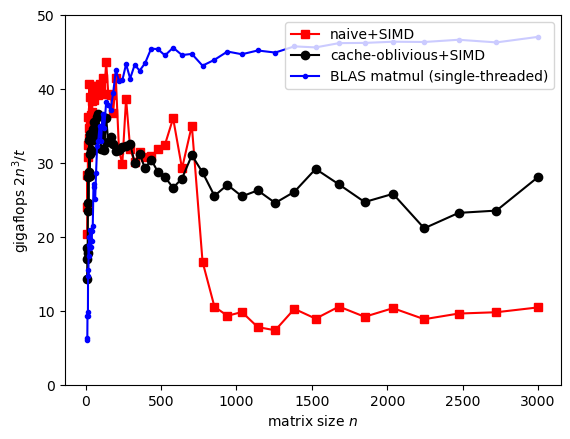

PyObject <matplotlib.legend.Legend object at 0x7f8d18a02dd0>

In [17]:
plot(N, 2N.^3 ./ tv * 1e-9, "rs-")
plot(N, 2N.^3 ./ tco * 1e-9, "ko-")
plot(N, 2N.^3 ./ t0 * 1e-9, "b.-")
ylim(0,50)
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive+SIMD", "cache-oblivious+SIMD", "BLAS matmul (single-threaded)"], loc="upper right")

## Matrix addition

Matrix addition is an interesting case because it has no data re-use, so there is no possible temporal locality, but depending on *what order* you use for the loops and *how matrices are stored* in memory, you may or may not get **spatial locality** that takes advantage of **cache lines**.

Here let's implement matrix addition in two different ways.  As above, we'll use a pre-allocated output array so that our benchmark does not include the time for memory allocation:

In [18]:
function matadd1!(C, A, B)
    size(C) == size(A) == size(B) || throw(DimensionMismatchmatch())
    m,n = size(A)
    for i = 1:m
        @simd for j = 1:n
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd1(A, B) = matadd1!(similar(A, promote_type(eltype(A), eltype(B))), A, B)

function matadd2!(C, A, B)
    size(C) == size(A) == size(B) || throw(DimensionMismatch())
    m,n = size(A)
    for j = 1:n
        @simd for i = 1:m
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd2(A, B) = matadd2!(similar(A, promote_type(eltype(A), eltype(B))), A, B)

A = rand(5,6)
B = rand(5,6)
A + B ≈ matadd1(A,B) ≈ matadd2(A,B)

true

In [19]:
Na = round.(Int, 10 .^ range(1, log10(3000), length=60))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t1 = Float64[]
t2 = Float64[]
for n in Na
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    matadd1!(C,A,B) # add once just to make sure we are in cache if A and B are small
    push!(t1, @belapsed matadd1!($C,$A,$B))
    push!(t2, @belapsed matadd2!($C,$A,$B))
    println("finished n = $n: ratio t1/t2 of ", t1[end]/t2[end])
end

finished n = 10: ratio t1/t2 of 1.0230625080301594
finished n = 11: ratio t1/t2 of 1.0686913725305058
finished n = 12: ratio t1/t2 of 1.0949888352129231
finished n = 13: ratio t1/t2 of 1.0825560142269264
finished n = 15: ratio t1/t2 of 1.0440187828083989
finished n = 16: ratio t1/t2 of 2.0463619261597166
finished n = 18: ratio t1/t2 of 1.8997204570255033
finished n = 20: ratio t1/t2 of 1.7882358742287783
finished n = 22: ratio t1/t2 of 1.749614054182348
finished n = 24: ratio t1/t2 of 1.7210357565446446
finished n = 26: ratio t1/t2 of 1.6955612908163085
finished n = 29: ratio t1/t2 of 1.6268502571988732
finished n = 32: ratio t1/t2 of 3.7985615003507647
finished n = 35: ratio t1/t2 of 2.184259278495316
finished n = 39: ratio t1/t2 of 2.636343399866439
finished n = 43: ratio t1/t2 of 2.5014325977133742
finished n = 47: ratio t1/t2 of 2.3754143845488613
finished n = 52: ratio t1/t2 of 3.9109653916211293
finished n = 57: ratio t1/t2 of 5.485032635606571
finished n = 63: ratio t1/t2 of 2.5

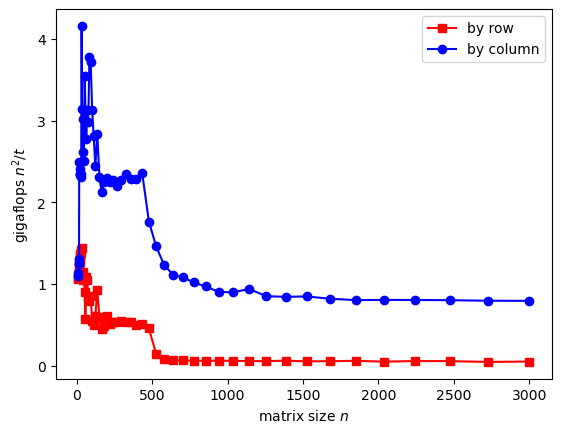

PyObject <matplotlib.legend.Legend object at 0x7f8ced4db7d0>

In [20]:
plot(Na, Na.^2 ./ t1 * 1e-9, "rs-")
plot(Na, Na.^2 ./ t2 * 1e-9, "bo-")
xlabel(L"matrix size $n$")
ylabel(L"gigaflops $n^2/t$")
legend(["by row", "by column"])

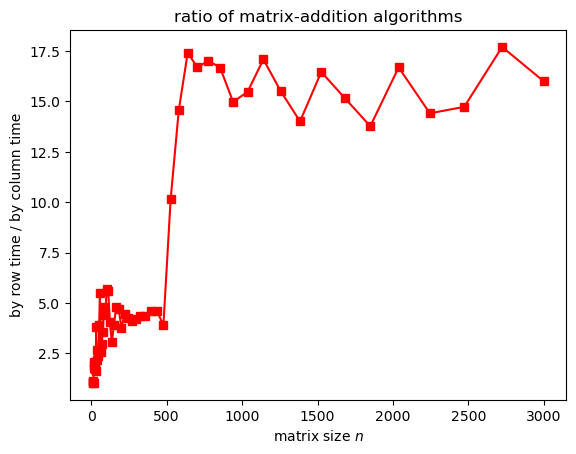

PyObject Text(0.5, 1.0, 'ratio of matrix-addition algorithms')

In [21]:
plot(Na, t1 ./ t2, "rs-")
xlabel(L"matrix size $n$")
ylabel("by row time / by column time")
title("ratio of matrix-addition algorithms")

We can see that addition is almost ***20 times slower*** if we add by rows rather than by columns.

The reason for this is that **Julia stores matrices with consecutive columns**, which is known as **column-major storage** format.

## Other examples: vectorized vs. devectorized operations

Another example of the importance of spatial locality can be seen in vectorized operations.  For more information on this subject, see the blog post:

* [More Dots: Syntactic Loop Fusion in Julia](https://julialang.org/blog/2017/01/moredots)

Consider the following function, which computes $f(x) = 2x^2 - 3x + 4$ *element-wise* for an array of $x$ values:

In [22]:
f_vec(x) = 2 * x.^2 - 3 * x .+ 4
f_devec(X) = f_vec.(X)

X = rand(10^6);

In [23]:
@btime f_vec($X);

  6.198 ms (10 allocations: 38.15 MiB)


In [24]:
@btime f_devec($X);

  1.020 ms (2 allocations: 7.63 MiB)


The `f_devec` function is more than **4 times faster** than the vectorized version, and allocates about **1/4 the memory**.   That is because `f_vec` is effectively equivalent to:

In [25]:
function f_vec_really(x)
    tmp1 = x.^2
    tmp2 = 2 * tmp1
    tmp3 = 3 * x
    tmp4 = tmp2 .- tmp3
    tmp5 = tmp4 .+ 4
    return tmp5
end

f_vec_really (generic function with 1 method)

That is, each "vectorized" operation, like `x.^2`, while it is *individually fast*, does a *separate loop* over its data and *allocates a temporary array for the result*.  This is slow for three reasons:

* It has poor temporal locality.
* It is expensive to allocate all those temporary arrays.
* The overhead of looping (incrementing/testing a counter, fetching elements `x[i]`, etcetera), is incurred multiple times rather than once.

In Julia, there is a  syntax `2 .* x.^2 .- 3 .* x .+ 4`, or equivalently `@. 2x^2 - 3x + 4` in which the compiler is guaranteed to "fuse" the operations into a single loop, allocating no temporary arrays.